## Д/з

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров. 
2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

Реализуем средствами Python алгоритм стохастического градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [37]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import random

Используем один из "игрушечных" датасетов из той же библиотеки.

In [4]:

from sklearn.datasets import load_diabetes

In [5]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [7]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [8]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [9]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [10]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Реализуем функцию обучения стохастического градиентного бустинга.

In [105]:
#coef_x - параметр, задающий какой размер исходный выборки брать для подвыборки на каждой 
#итерации стохастического град. спуска
def stohastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, coef_x):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
 
    #создаем выборку для стохастического градиента
    num_elem = round(len(X_train)*coef_x)

    for i in range(n_trees):
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)
        
        rand_start = random.randint(0,round(len(X_train)/2))
        X_current = X_train[rand_start:(rand_start+num_elem)]
        Y_current = y_train[rand_start:(rand_start+num_elem)]
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_current, Y_current)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_current, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_current, bias(Y_current, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [119]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.19

#параметр, задающий какой размер исходный выборки брать для подвыборки на каждой 
#итерации стохастического град. спуска
coef_x = 0.5
stohastic_trees, train_errors, test_errors = stohastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, coef_x)

In [120]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [121]:
evaluate_alg(X_train, X_test, y_train, y_test, stohastic_trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.19 на тренировочной выборке: 1380.610784512692
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.19 на тестовой выборке: 3425.433827022012


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [123]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [124]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

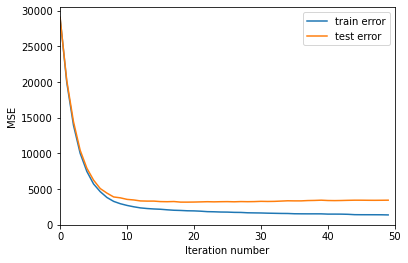

In [125]:
get_error_plot(n_trees, train_errors, test_errors)

На этом графике мы видим переобучение.

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_moons



In [30]:
data,labels = make_moons( n_samples=500, noise= 0.2)

data.shape

(500, 2)

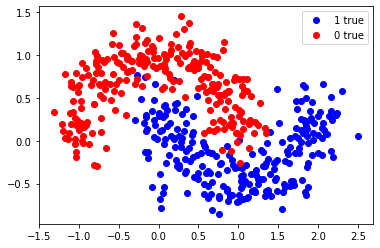

In [31]:
plt.plot(data[labels==1,0],data[labels==1,1],'ob')
plt.plot(data[labels==0,0],data[labels==0,1],'or')
plt.legend(['1 true','0 true'])    
plt.show()

In [32]:
# Число деревьев в ансамбле
n_trees = 16
# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees
# Максимальная глубина деревьев
max_depth = 3
# Шаг
eta = 0.19
X_tr, X_t, y_tr, y_t = model_selection.train_test_split(data, labels, test_size=0.25)

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_tr, X_t, y_tr, y_t, coefs, eta)

In [33]:
X_t.shape

(125, 2)

Построим графики зависимости ошибки от количества количества деревьев в ансамбле

In [127]:
train_errors = []
test_errors = []
# Максимальная глубина деревьев  
max_depth = 3
# Шаг
eta = 0.19
for n in range(1, 25):
    n_trees = n
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees
 
    X_tr, X_t, y_tr, y_t = model_selection.train_test_split(data, labels, test_size=0.25)

    trees, train_errors_list, test_errors_list = gb_fit(n_trees, max_depth, X_tr, X_t, y_tr, y_t, coefs, eta)
    
    train_errors.append(train_errors_list[-1])
    test_errors.append(test_errors_list[-1])

In [129]:
train_errors = np.array(train_errors)
test_errors = np.array(test_errors)

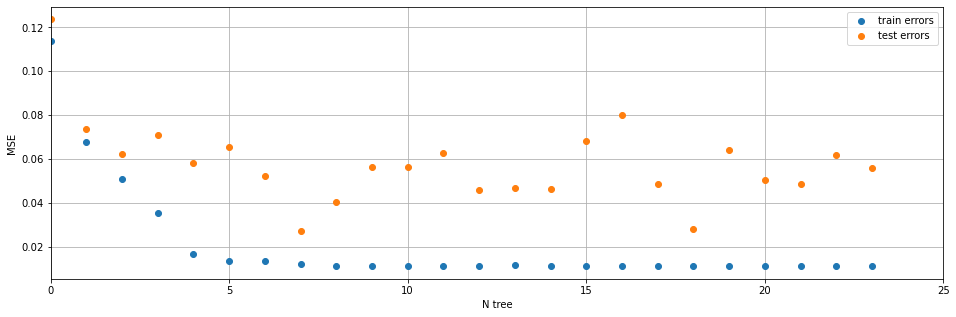

In [137]:
x = list(range(1, 25))
plt.figure(figsize = (16,5))
plt.xlim(0, 25)
plt.plot(train_errors,'o', label='train errors')
plt.plot(test_errors,'o', label='test errors')
plt.xlabel('N tree')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [133]:
train_errors = []
test_errors = []
# Максимальная глубина деревьев  
n_trees = 10
# Шаг
eta = 0.19
for n in range(1, 25):
    max_depth = n
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees
 
    X_tr, X_t, y_tr, y_t = model_selection.train_test_split(data, labels, test_size=0.25)

    trees, train_errors_list, test_errors_list = gb_fit(n_trees, max_depth, X_tr, X_t, y_tr, y_t, coefs, eta)
    
    train_errors.append(train_errors_list[-1])
    test_errors.append(test_errors_list[-1])

In [134]:
train_errors = np.array(train_errors)
test_errors = np.array(test_errors)

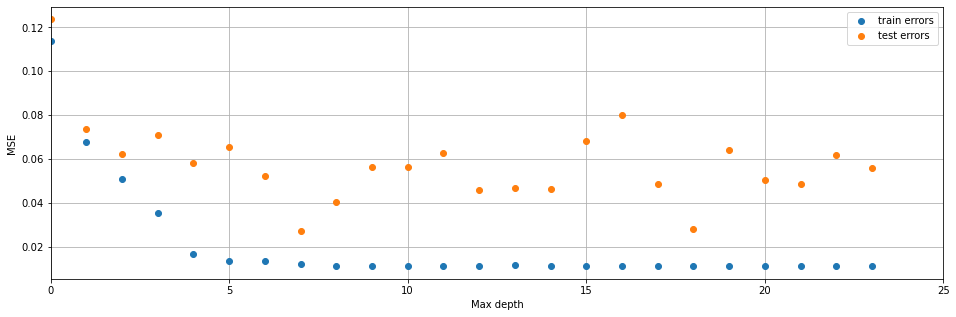

In [139]:
x = list(range(1, 25))
plt.figure(figsize = (16,5))
plt.xlim(0, 25)
plt.plot(train_errors,'o', label='train errors')
plt.plot(test_errors,'o', label='test errors')
plt.xlabel('Max depth')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()